# Python Basics

---
## Tutorial objectives
You are going to use Python skills to advance your understanding of neuroscience. Just like two legs that support and strengthen each other. One has "Python" written in it, and the other has "Neuro". And step-by-step they go.

In this notebook, we'll practice basic operations with Python variables, control flow, plotting, and a sneak peek at `np.array`, the workhorse of scientific computation in Python. 

Each new concept in Python will unlock a different aspect of our implementation of a **Leaky Integrate-and-Fire (LIF)** neuron. And as if it couldn't get any better, we'll visualize the evolution of its membrane potential in time, and extract its statistical properties! 

Note:- Whenever you get stuck at any function, you can just google the function and you will find the official documentation of that function and there you can go through the arguments and figure out how to complete the corresponding code.

Well then, let's start our walk today!

Aknowledgment:- This notebook has been made with the help of the notebooks by *Neuromatch Academy*.

---
## Imports and helper functions
Please execute the cell(s) below to initialize the notebook environment.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo

---
## Neuron model
A *leaky-integrate-and-fire (LIF)* neuron is defined by the following *membrane equation* and *reset condition*:


\begin{align*}
\\
&\tau_m\,\frac{d}{dt}\,V(t) = E_{L} - V(t) + R\,I(t) &\text{if }\quad V(t) \leq V_{th}\\
\\
&V(t) = V_{reset} &\text{otherwise}\\
\\
\end{align*}

where $V(t)$ is the membrane potential, $\tau_m$ is the membrane time constant, $E_{L}$ is the leak potential, $R$ is the membrane resistance, $I(t)$ is the synaptic input current, $V_{th}$ is the firing threshold, and $V_{reset}$ is the reset voltage. We can also write $V_m$ for membrane potential - very convenient for plot labels.

The membrane equation is an *ordinary differential equation (ODE)* that describes the time evolution of membrane potential $V(t)$ in response to synaptic input and leaking of change across the cell membrane.

**Note that, in this tutorial the neuron model will not implement a spiking mechanism.**

Video available at https://youtube.com/watch?v=UP8rD2AwceM


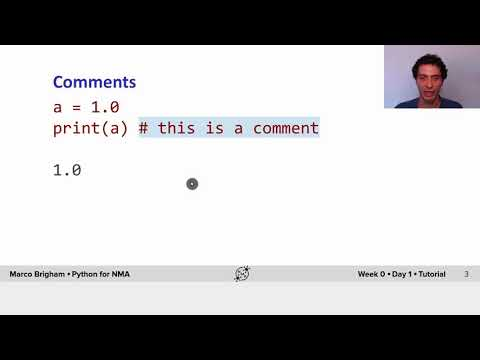

In [2]:
# @title Video: Synaptic input
video = YouTubeVideo(id='UP8rD2AwceM', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

In [3]:
# the stimulation parameters have been defined below
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # milivolt
vr = -70e-3      # milivolt
vth = -50e-3     # milivolt
r = 100e6        # ohm
i_mean = 25e-11  # ampere

print(t_max, dt, tau, el, vr, vth, r, i_mean)

0.15 0.001 0.02 -0.06 -0.07 -0.05 100000000.0 2.5e-10


### Exercise 1
![synaptic input](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/synaptic_input.png)

We start with a sinusoidal model, with a shift from origin, to simulate the synaptic input $I(t)$ given by:
\begin{align*}
\\
I(t)=I_{mean}\left(1+\sin\left(\frac{2 \pi}{0.01}\,t\right)\right)\\
\\
\end{align*}

Compute and print the values of synaptic input $I(t)$ between $t=0$ and $t=0.009$ with step $\Delta t=0.001$.


We will write a `for` loop from scratch in this exercise. The following three formulations are all equivalent and loop for three steps:
```
1.  for step in [0, 1, 2]:
      print(step)

2.  for step in range(3):
      print(step)

3.  start = 0
    end = 3
    stepsize = 1

    for step in range(start, end, stepsize):
       print(step)
```

**Suggestions**
* Loop variable `step` for 10 steps (`step` takes values from `0` to `9`)
* At each time step
    * Compute the value of `t` with variables `step` and `dt`
    * Compute the value of `i`
    * Print `i`
* Use `np.pi` and `np.sin` for evaluating $\pi$ and $\sin(\cdot)$, respectively


In [4]:
# initialize t to zero
t = 0

# loop for 10 steps, variable 'step' takes values from 0 to 9
for step in range(10):
  t = step * dt
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
  print(i)

2.5e-10
3.969463130731183e-10
4.877641290737885e-10
4.877641290737885e-10
3.9694631307311837e-10
2.5000000000000007e-10
1.0305368692688176e-10
1.2235870926211617e-11
1.223587092621159e-11
1.0305368692688186e-10


## ODE integration without spikes
Now we can write the previous equation in the following form:- 

\begin{align*}
\\
&\tau_m\,\lim_{\Delta t \to 0}{\frac{V\left(t+\Delta t\right)-V\left(t\right)}{\Delta t}} = E_{L} - V(t) + R\,I(t)\\
&\implies V(t+\Delta t) = V(t) + \frac{\Delta t}{\tau_m}(E_{L} - V(t) + R\,I(t))\\ 
\\
\end{align*}

For sufficiently *small enough* values of $\Delta t$, we can estimate the value of membrane potential $V\left(t+\Delta t\right)$ using its previous value $V(t)$ by simple algebraic manipulation. 

This provides a good approximation of the continuous-time integration. This operation is an integration since we obtain a sequence $\{V(t), V(t+\Delta t), V(t+2\Delta t),...\}$ starting from the ODE. For the evolution of $V(t)$ we need to integrate the ODE, and in this tutorial, we will do a discrete-time integration using the Euler method. In the next exercises, we will simulate the evolution of the membrane equation in discrete time steps, with a sufficiently small $\Delta t$.

Video available at https://youtube.com/watch?v=kyCbeR28AYQ


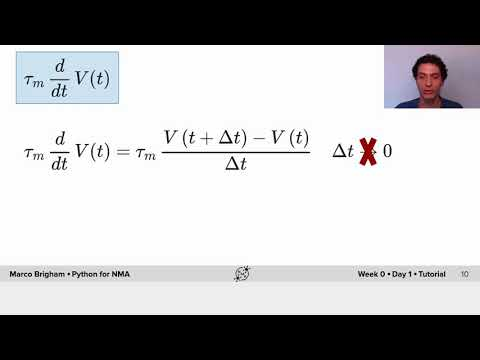

In [5]:
# @title Video: Discrete time integration
video = YouTubeVideo(id='kyCbeR28AYQ', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 2
Compute the values of $V(t)$ between $t=0$ and $t=0.01$ with step $\Delta t=0.001$ and $V(0)=E_L$.


**Suggestions**
* Reorganize the Eq. (1) to isolate $V\left(t+\Delta t\right)$ on the left side, and express it as function of $V(t)$ and the other terms
* Initialize the membrane potential variable `v` to leak potential `el`
* Loop variable `step` for `10` steps
* At each time step
    * Compute the current value of `t`, `i`
    * Print the current value of `t` and `v`
    * Update the value of `v`

In [6]:
# initialize step_end and v
step_end = 10
v = el

# loop for step_end steps
for step in range(step_end):
  t = step * dt#
  i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
  print(f"{t:.3f} {v:.4e}")
  v = v + dt/tau * (el - v + r*i)

0.000 -6.0000e-02
0.001 -5.8750e-02
0.002 -5.6828e-02
0.003 -5.4548e-02
0.004 -5.2381e-02
0.005 -5.0778e-02
0.006 -4.9989e-02
0.007 -4.9974e-02
0.008 -5.0414e-02
0.009 -5.0832e-02


Video available at https://youtube.com/watch?v=BOh8CsuTFkY


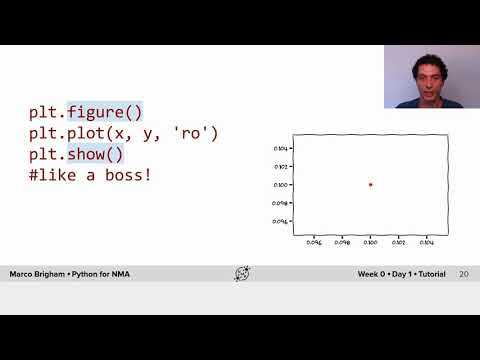

In [7]:
# @title Video: Plotting
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='BOh8CsuTFkY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 3
![synaptic input discrete](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/synaptic_input_discrete.png)

Plot the values of $I(t)$ between $t=0$ and $t=0.024$.

**Suggestions**
* Initialize `step_end`
* initialize the figure with `plt.figure()`, set title, x and y labels with `plt.title()`, `plt.xlabel()` and `plt.ylabel()`, respectively
* Replace printing command `print()` with plotting command `plt.plot()` with argument `'ko'` (short version for `color='k'` and `marker='o'`) for black small dots
* Use `plt.show()` at the end to display the plot

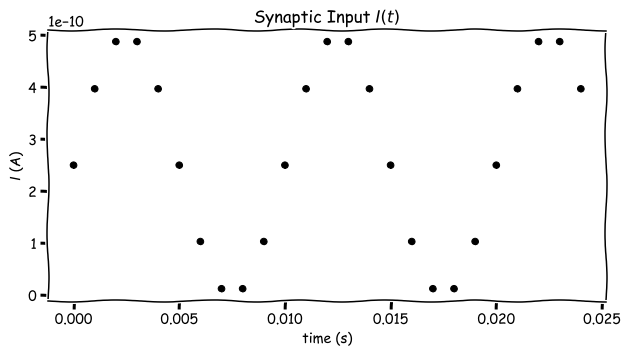

In [8]:
# initialize step_end
step_end = 25
with plt.xkcd():
    # initialize the figure
    plt.figure(figsize=(10,5))
    plt.title('Synaptic Input $I(t)$')
    plt.xlabel('time (s)')
    plt.ylabel('$I$ (A)')

    # loop for step_end steps
    for step in range(step_end):
      t = step * dt 
      i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
      plt.plot(t, i, 'ko')

plt.show()

### Exercise 4
Plot the values of $V(t)$ between $t=0$ and $t=t_{max}$.

**Suggestions**
* Compute the required number of steps with`int(t_max/dt)`
* Use plotting command for black small(er) dots with argument `'k.'`

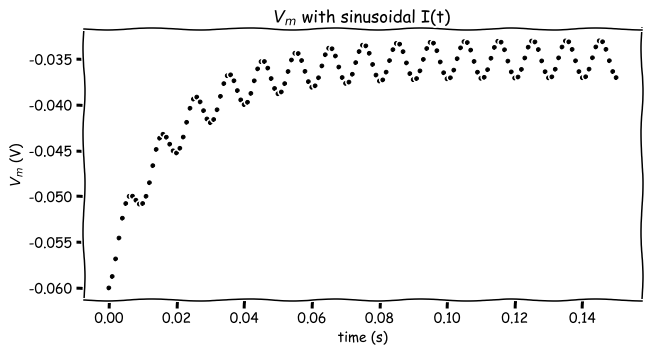

In [9]:
# initialize step_end and v
step_end = int(t_max / dt)
v = el

with plt.xkcd():
  # initialize the figure
  plt.figure(figsize=(10,5))
  plt.title('$V_m$ with sinusoidal I(t)')#
  plt.xlabel('time (s)')#
  plt.ylabel('$V_m$ (V)');#
  # loop for step_end steps
  for step in range(step_end):
    t = step * dt
    i = i_mean * (1 + np.sin((t * 2 * np.pi) / 0.01))
    plt.plot(t, v, 'k.')

    v = v + dt/tau * (el - v + r*i)

  t = t + dt
  plt.plot(t, v, 'k.')
  plt.show()

---
## Random synaptic input
From the perspective of neurons, synaptic input is random (or stochastic). We'll improve the synaptic input model by introducing random input current with statistical properties similar to the previous exercise:

\begin{align*}
\\
I(t)=I_{mean}\left(1+0.1\sqrt{\frac{t_{max}}{\Delta t}}\,\xi(t)\right)\qquad\text{with }\xi(t)\sim U(-1,1)\\
\\
\end{align*}

where $U(-1,1)$ is the [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)) with support $x\in[-1,1]$.

Random synaptic input $I(t)$ results in random time course for $V(t)$.

### Exercise 5
Plot the values of $V(t)$ between $t=0$ and $t=t_{max}-\Delta t$ with random input $I(t)$.

The function `np.random.seed()` initializes the RNG, and `np.random.random()` generates samples from the uniform distribution between `0` and `1`.

**Suggestions**
* Use `np.random.seed()` to initialize the RNG to `0`
* Use `np.random.random()` to generate random input in range `[0,1]` at each timestep
* Multiply random input by an appropriate factor to expand the range to `[-1,1]`
* Verify that $V(t)$ has a random time course by changing the initial RNG value
* Alternatively, comment RNG initialization by typing `CTRL` + `\` in the relevant line

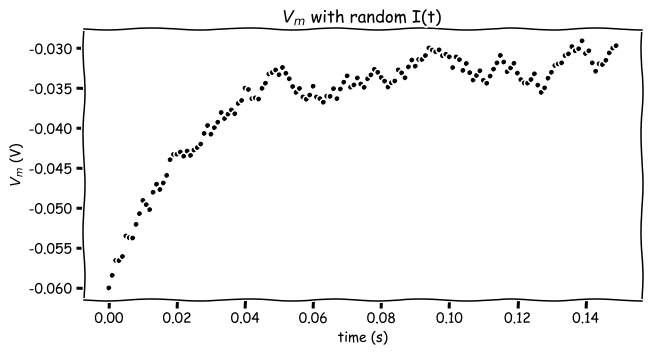

In [10]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end and v
step_end = int(t_max / dt)
v = el
t = 0

with plt.xkcd():
  plt.figure(figsize=(10,5))
  plt.title('$V_m$ with random I(t)')
  plt.xlabel('time (s)')
  plt.ylabel('$V_m$ (V)')

  # loop for step_end steps
  for step in range(step_end):
    t = step * dt
    plt.plot(t, v, 'k.')
    i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random() - 1))
    v = v + (dt / tau) * (el - v + r * i)

  plt.show()

## Ensemble statistics
If we run the previous exercise multiple times, it may give us the impression of periodic regularity in the evolution of $V(t)$. We'll collect the sample mean over $N=50$ realizations of $V(t)$  with random input to test such a hypothesis. The sample mean, sample variance and sample auto-covariance at times $\left\{t, s\right\}\in[0,t_{max}]$, and for $N$ realizations $V_n(t)$ are given by:

\begin{align*}
\\
\left\langle V(t)\right\rangle &= \frac{1}{N}\sum_{n=1}^N V_n(t) & & \text{sample mean}\\
\left\langle (V(t)-\left\langle V(t)\right\rangle)^2\right\rangle &= \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)^2 & & \text{sample variance} \\
\left\langle \left(V(t)-\left\langle V(t)\right\rangle\right)\left(V(s)-\left\langle V(s)\right\rangle\right)\right\rangle
&= \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)\left(V_n(s)-\left\langle V(s)\right\rangle\right) & & \text{sample autocovariance}\\
\\
\end{align*}

Video available at https://youtube.com/watch?v=4nIAS2oPEFI


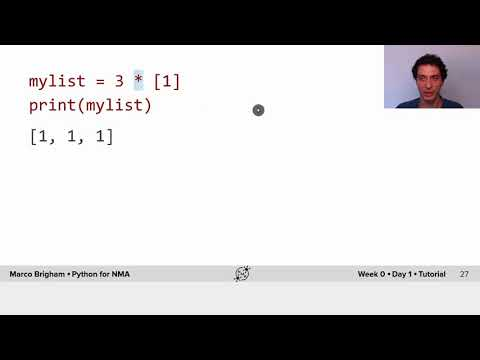

In [11]:
# @title Video: Ensemble statistics
video = YouTubeVideo(id='4nIAS2oPEFI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 6
Plot multiple realizations ($N=50$) of $V(t)$ by storing in a list the voltage of each neuron at time $t$.

**Suggestions**
* Initialize a list `v_n` with `50` values of membrane leak potential `el`
* At each time step:
  * Plot `v_n` with argument `'k.'` and parameter `alpha=0.05` to adjust the transparency (by default, `alpha=1`)
  * In the plot command, replace `t` from the previous exercises with a list of size `n` with values `t`
  * Loop over `50` realizations of random input
  * Update `v_n` with the values of $V(t)$

* Why is there a black dot at $t=0$?

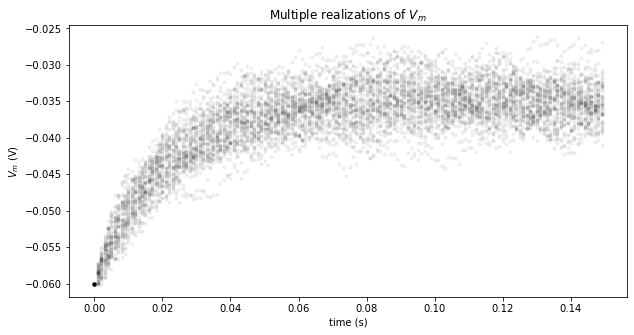

In [12]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, n and v_n
step_end = int(t_max / dt)
n = 50
v_n = [el] * n

# initialize the figure
plt.figure(figsize=(10,5))
plt.title('Multiple realizations of $V_m$')#
plt.xlabel('time (s)')#
plt.ylabel('$V_m$ (V)')#

# loop for step_end steps
for step in range(step_end):
  t = step * dt
  plt.plot([t] * n, v_n, 'k.', alpha=0.05)#

  # loop for n steps
  for j in range(0, n):
    i = i_mean * (1 + 0.1 * (t_max/dt)**(0.5) * (2* np.random.random() - 1))#
    v_n[j] = v_n[j] + (dt / tau) * (el - v_n[j] + r*i)#

plt.show()

### Exercise 7
Add the sample mean $\left\langle V(t)\right\rangle=\frac{1}{N}\sum_{n=1}^N V_n(t)$ to the plot.

**Suggestions**
* At each timestep:
  * Compute and store in `v_mean` the sample mean $\left\langle V(t)\right\rangle$ by summing the values of list `v_n` with `sum` and dividing by `n`
  * Plot $\left\langle V(t)\right\rangle$ with `alpha=0.8` and argument `'C0.'` for blue (you can read more about [specifying colors](https://matplotlib.org/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py))
  * Loop over `50` realizations of random input
  * Update `v_n` with the values of $V(t)$

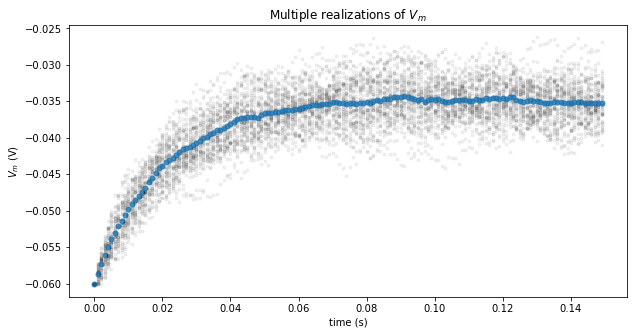

In [13]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, n and v_n
step_end = int(t_max / dt)
n = 50
v_n = [el] * n

# initialize the figure
plt.figure(figsize=(10,5))
plt.title('Multiple realizations of $V_m$')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (V)')

# loop for step_end steps
for step in range(step_end):
  t = step * dt

  v_mean = sum(v_n) / n
  plt.plot(n*[t], v_n, 'k.', alpha=0.05)
  plt.plot(t, v_mean, 'C0.', alpha=0.8, markersize=10)

  for j in range(0, n):
    i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random() - 1))
    v_n[j] = v_n[j] + (dt / tau) * (el - v_n[j] + r*i)

plt.show()

### Exercise 8
Add the sample standard deviation $\sigma(t)\equiv\sqrt{\text{Var}\left(t\right)}$ to the plot, with sample variance $\text{Var}(t) = \frac{1}{N-1} \sum_{n=1}^N \left(V_n(t)-\left\langle V(t)\right\rangle\right)^2$.

Use a list comprehension to collect the sample variance `v_var`. Here's an example to initialize a list with squares of `0` to `9`:
```
squares = [x**2 for x in range(10)]
print(squares)
--> [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
```

Why are we plotting $\sigma(t)$ rather than the $\text{Var}(t)$? What are the units of each and the units of $\left\langle V(t)\right\rangle$?

**Suggestions**
* At each timestep:
  * Compute and store in `v_mean` the sample mean $\left\langle V(t)\right\rangle$
  * Initialize a list `v_var_n` with the contribution of each $V_n(t)$ to $\text{Var}\left(t\right)$ with a list comprehension over values of `v_n`
  * Compute sample variance `v_var` by summing the values of `v_var_n` with `sum` and dividing by `n-1`
  * (alternative: loop over the values of `v_n` and add to `v_var` each contribution $V_n(t)$ and divide by `n-1` outside the loop)
  * Compute the standard deviation `v_std` with the function `np.sqrt`
  * Plot $\left\langle V(t)\right\rangle\pm\sigma(t)$ with `alpha=0.8` and argument `'C7.'`

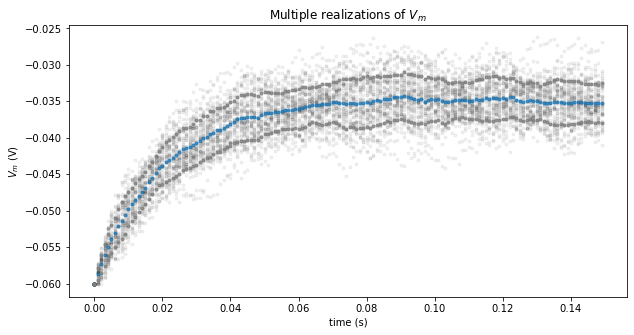

In [14]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, n and v_n
step_end = int(t_max / dt)
n = 50
v_n = [el] * n

# initialize the figure
plt.figure(figsize=(10,5))
plt.title('Multiple realizations of $V_m$')#
plt.xlabel('time (s)')#
plt.ylabel('$V_m$ (V)')#

# loop for step_end steps
for step in range(step_end):
  t = step * dt

  v_mean = sum(v_n) / n#
  v_var_n = [(v - v_mean)**2 for v in v_n]#
  v_var = sum(v_var_n) / (n - 1)#
  v_std = np.sqrt(v_var)#

  plt.plot(n*[t], v_n, 'k.', alpha=0.05)#
  plt.plot(t, v_mean, 'C0.', alpha=0.8)#
  plt.plot(t, v_mean + v_std, 'C7.', alpha=0.8)#
  plt.plot(t, v_mean - v_std, 'C7.', alpha=0.8)#

  for j in range(0, n):
    i = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random() - 1))#
    v_n[j] = v_n[j] + (dt / tau) * (el - v_n[j] + r*i)#

plt.show()

---
## Using NumPy
The next set of exercises introduces `np.array`, the workhorse from the scientific computation package [NumPy](https://numpy.org). Numpy arrays the default for numerical data storage and computation and will separate computing steps from plotting.

![NumPy package](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/numpy_logo_small.png)

We updated plots inside the main loop in the previous exercises and stored intermediate results in lists for plotting them. The purpose was to simplify earlier exercises as much as possible. However, there are very few scenarios where this technique is necessary, and you should avoid it in the future. Using numpy arrays will significantly simplify our coding narrative by computing inside the main loop and plotting afterward.

Lists are much more natural for storing data for other purposes than computation. For example, lists are handy for storing numerical indexes and text.

Video available at https://youtube.com/watch?v=ewyHKKa2_OU


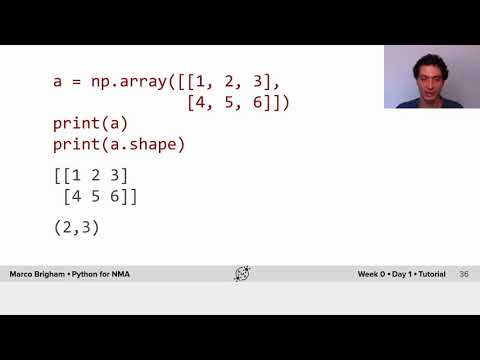

In [15]:
# @title Video: Using NumPy
video = YouTubeVideo(id='ewyHKKa2_OU', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 9
Rewrite the single neuron plot with random input from _Exercise 7_ with numpy arrays. The time range, voltage values, and synaptic current are initialized or pre-computed as numpy arrays before numerical integration.

**Suggestions**
* Use `np.linspace` to initialize a numpy array `t_range` with `num=step_end=150` values from `0` to `t_max`
* Use `np.ones` to initialize a numpy array `v` with `step_end + 1` leak potential values `el`
* Pre-compute `step_end` synaptic current values in numpy array `syn` with `np.random.random(step_end)` for `step_end` random numbers
* Iterate for numerical integration of `v`
* Since `v[0]=el`, we should iterate for `step_end` steps, for example by skipping `step=0`. Why?

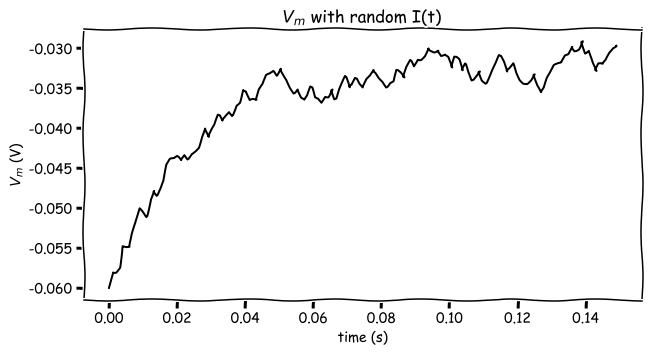

In [16]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, t_range, v and syn
step_end = int(t_max / dt) - 1
# skip the endpoint to match Exercise 5 plot
t_range = np.linspace(0, t_max, num=step_end, endpoint=False)
v = el * np.ones(step_end)
syn = i_mean * (1 + 0.1 * (t_max/dt) ** (0.5) * (2 * np.random.random(step_end) - 1))

# loop for step_end - 1 steps
for step in range(1, step_end):
  v[step] = v[step - 1] + (dt / tau) * (el - v[step - 1] + r * syn[step])

with plt.xkcd():
  # initialize the figure
  plt.figure(figsize=(10,5))
  plt.title('$V_m$ with random I(t)')
  plt.xlabel('time (s)')
  plt.ylabel('$V_m$ (V)')

  plt.plot(t_range, v, 'k')
  plt.show()

### Exercise 10
Let's practice using `enumerate` to iterate over the indexes and values of the synaptic current array `syn`.

**Suggestions**
* Iterate indexes and values of `syn` with `enumerate` in the `for` loop
* Plot `v` with argument `'k'` for displaying a line instead of dots

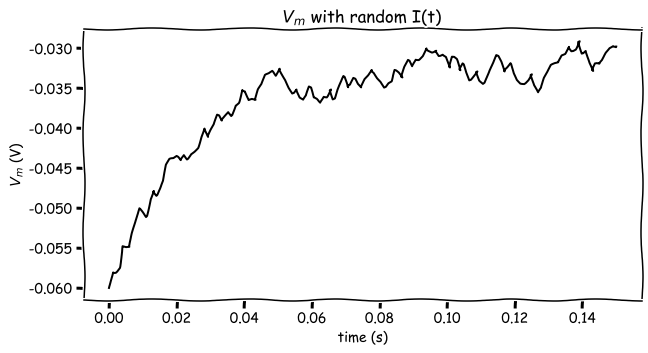

In [17]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, t_range, v and syn
step_end = int(t_max / dt)
t_range = np.linspace(0, t_max, num=step_end)
v = el * np.ones(step_end)
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random(step_end) - 1))

# loop for step_end values of syn
for step, i in enumerate(syn):
  # skip first iteration
  if step==0:
    continue
  v[step] = v[step - 1] + (dt / tau) * (el - v[step - 1] + r*i)

with plt.xkcd():
  # initialize the figure
  plt.figure(figsize=(10,5))
  plt.title('$V_m$ with random I(t)')
  plt.xlabel('time (s)')
  plt.ylabel('$V_m$ (V)')

  plt.plot(t_range, v, 'k')
  plt.show()

Video available at https://youtube.com/watch?v=1ME-0rJXLFg


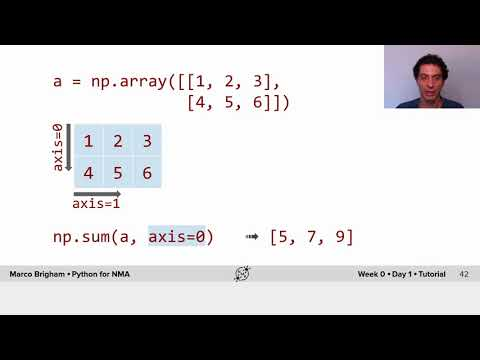

In [18]:
# @title Video: Aggregation
video = YouTubeVideo(id='1ME-0rJXLFg', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 11
Plot multiple realizations ($N=50$) of $V(t)$ by storing the voltage of each neuron at time $t$ in a numpy array.

**Suggestions**
* Initialize a numpy array `v_n` of shape `(n, step_end)` with membrane leak potential values `el`
* Pre-compute synaptic current values in numpy array `syn` of shape `(n, step_end)`
* Iterate `step_end` steps with a `for` loop for numerical integration
* Plot results with a single plot command, by providing `v_n.T` to the plot function. `v_n.T` is the transposed version of `v_n` (with rows and columns swapped).

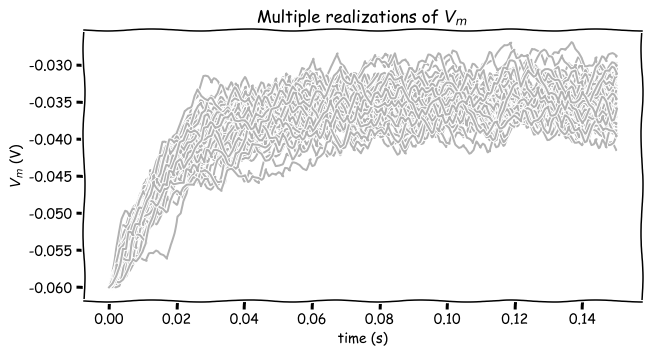

In [19]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, n, t_range, v and syn
step_end = int(t_max / dt)
n = 50
t_range = np.linspace(0, t_max, num=step_end)
v_n = el * np.ones([n, step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# loop for step_end - 1 steps
for step in range(1, step_end):
  v_n[:, step] = v_n[:, step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r * syn[:, step])

with plt.xkcd():
  # initialize the figure
  plt.figure(figsize=(10,5))
  plt.title('Multiple realizations of $V_m$')
  plt.xlabel('time (s)')
  plt.ylabel('$V_m$ (V)')

  plt.plot(t_range, v_n.T, 'k', alpha=0.3)
  plt.show()

### Exercise 12
Add sample mean $\left\langle V(t)\right\rangle$ and standard deviation $\sigma(t)\equiv\sqrt{\text{Var}\left(t\right)}$ to the plot.

`np.mean(v_n, axis=0)` computes mean over rows, i.e. mean for each neuron

`np.mean(v_n, axis=1)` computes mean over columns (axis `1`), i.e. mean for each time step

**Suggestions**
* Use `np.mean` and `np.std` with `axis=0` to sum over neurons
* Use `label` argument in `plt.plot` to specify labels in each trace. Label only the last voltage trace to avoid labeling all `N` of them.

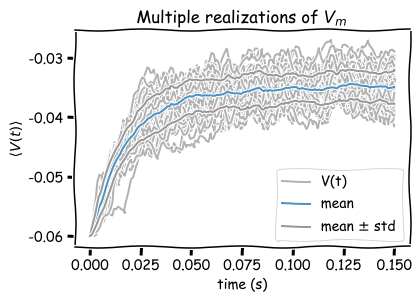

In [26]:
# the random number generator (RNG) is fixed below to obtain the same random input each time.
np.random.seed(2021)

# initialize step_end, n, t_range, v and syn
step_end = int(t_max / dt)
n = 50
t_range = np.linspace(0, t_max, num=step_end)
v_n = el * np.ones([n, step_end])
syn = i_mean * (1 + 0.1 * (t_max / dt)**(0.5) * (2 * np.random.random([n, step_end]) - 1))

# loop for step_end - 1 steps
for step in range(1, step_end):
  v_n[:,step] = v_n[:,step - 1] + (dt / tau) * (el - v_n[:, step - 1] + r * syn[:, step])

v_mean = np.mean(v_n, axis=0)
v_std = np.std(v_n, axis=0)

with plt.xkcd():
  # initialize the figure
  plt.figure()
  plt.title('Multiple realizations of $V_m$')
  plt.xlabel('time (s)')
  plt.ylabel(r'$\langle V(t) \rangle$')

  plt.plot(t_range, v_n[:-1].T, 'k', alpha=0.3)

  plt.plot(t_range, v_n[-1], 'k', alpha=0.3, label='V(t)')
  plt.plot(t_range, v_mean, 'C0', alpha=0.8, label='mean')
  plt.plot(t_range, v_mean+v_std, 'C7', alpha=0.8)
  plt.plot(t_range, v_mean-v_std, 'C7', alpha=0.8, label='mean $\pm$ std')

  plt.legend()
  plt.show()